Set a path to be used to test the steering and throttle control.<br>
Get waypoints from inner ring, path_index = 0 <br>
first_point_guess = (-11, 4)  # You can change this to any (x, y) coordinate<br>
Consider **21. Calculate the angle between points, add  lookahead and speed** when calculating angles<br>
Calculation of Points 3-8:
- Point 3: Located at a distance of 'distance_2_to_3' from Point 2 Forms a right angle with the line segment from Point 1 to Point 2 Direction: 90 degrees counterclockwise from the vector Point 1 to Point 2
- Point 4: Located at a distance of 'distance_2_to_3' from Point 1 Forms a right angle with the line segment from Point 1 to Point 2 Direction: 90 degrees counterclockwise from the vector Point 1 to Point 2
- Point 5: Midpoint of the line segment connecting Point 3 and Point 4
- Point 6: Located at a distance of 'distance_5_to_6' from Point 5 Forms a right angle with the line segment from Point 3 to Point 5 Direction: 90 degrees counterclockwise from the vector Point 3 to Point 5
- Point 7: Located at a distance of 'distance_2_to_3' from Point 6 Forms a right angle with the line segment from Point 5 to Point 6 Direction: 90 degrees clockwise from the vector Point 5 to Point 6
- Point 8: Located at a distance of 'distance_5_to_6' from Point 7 Parallel to the line segment from Point 5 to Point 6 Direction: Opposite to the vector Point 5 to Point 6



Key Distances:
- 'distance_2_to_3': Distance between Points 2 and 3, also used for Points 1 and 4, and Points 6 and 7
- 'distance_5_to_6': Distance between Points 5 and 6, also used for Points 7 and 8

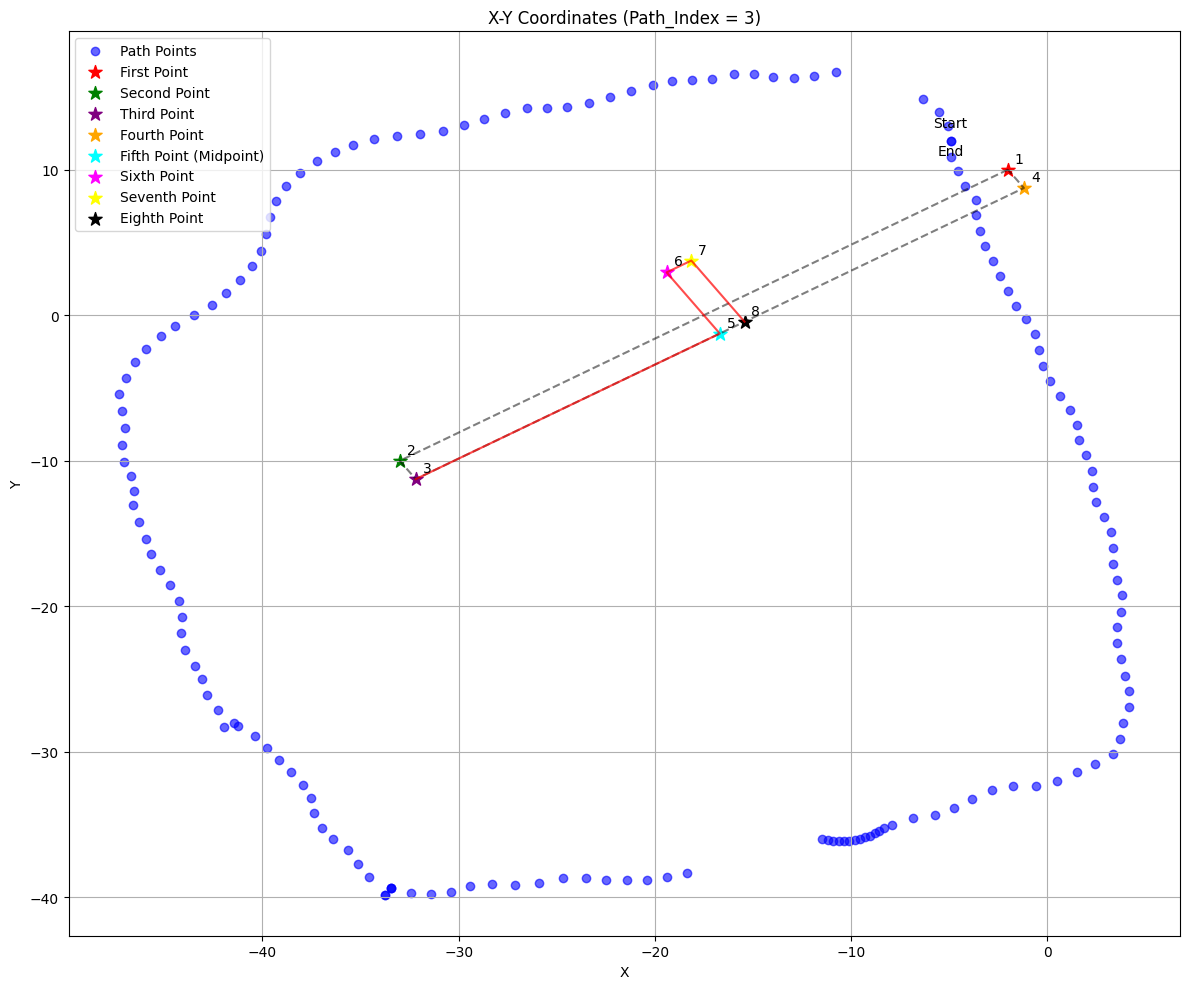

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# File path
xlsx_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/collins_dr_62_A_from_rosbag_step1_20240513_2.xlsx'

# Define the guess points and distances as variables
first_point_guess = (-2, 10)
second_point_guess = (-33, -10)
distance_2_to_3 = 1.5  # Distance between point 2 and point 3 (and point 1 and point 4)
distance_5_to_6 = 5  # Distance from point 5 to 6 (and 7 to 8)

def calculate_rectangle_points(p1, p2, distance):
    v_x = p2[0] - p1[0]
    v_y = p2[1] - p1[1]
    perp_x, perp_y = -v_y, v_x
    length = math.sqrt(perp_x**2 + perp_y**2)
    perp_x, perp_y = perp_x / length * distance, perp_y / length * distance
    p3 = (p2[0] + perp_x, p2[1] + perp_y)
    p4 = (p1[0] + perp_x, p1[1] + perp_y)
    p5 = ((p3[0] + p4[0]) / 2, (p3[1] + p4[1]) / 2)
    return p3, p4, p5

def calculate_additional_points(p3, p5, distance_5_to_6, distance_6_to_7):
    # Vector from p3 to p5
    v_x = p5[0] - p3[0]
    v_y = p5[1] - p3[1]
    
    # Normalize the vector
    length = math.sqrt(v_x**2 + v_y**2)
    v_x, v_y = v_x / length, v_y / length
    
    # Rotate 90 degrees left for direction to p6
    dir_6_x, dir_6_y = -v_y, v_x
    
    # Calculate p6
    p6 = (p5[0] + dir_6_x * distance_5_to_6, p5[1] + dir_6_y * distance_5_to_6)
    
    # Direction for p7 (90 degrees right from p5 to p6)
    dir_7_x, dir_7_y = v_x, v_y
    
    # Calculate p7
    p7 = (p6[0] + dir_7_x * distance_6_to_7, p6[1] + dir_7_y * distance_6_to_7)
    
    # Direction for p8 (opposite of p5 to p6)
    p8 = (p7[0] - dir_6_x * distance_5_to_6, p7[1] - dir_6_y * distance_5_to_6)
    
    return p6, p7, p8

def plot_points(df_filtered, points):
    plt.figure(figsize=(12, 10))
    plt.scatter(df_filtered['X'], df_filtered['Y'], color='blue', alpha=0.6, label='Path Points')
    
    colors = ['red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black']
    labels = ['First Point', 'Second Point', 'Third Point', 'Fourth Point', 'Fifth Point (Midpoint)', 
              'Sixth Point', 'Seventh Point', 'Eighth Point']
    
    for i, (point, color, label) in enumerate(zip(points, colors, labels), 1):
        plt.scatter(point[0], point[1], color=color, s=100, marker='*', label=label)
        plt.annotate(f'{i}', (point[0], point[1]), xytext=(5,5), textcoords='offset points')

    # Draw lines connecting the points
    plt.plot([points[0][0], points[1][0], points[2][0], points[3][0], points[0][0]], 
             [points[0][1], points[1][1], points[2][1], points[3][1], points[0][1]], 'k--', alpha=0.5)
    plt.plot([points[2][0], points[4][0], points[5][0], points[6][0], points[7][0]], 
             [points[2][1], points[4][1], points[5][1], points[6][1], points[7][1]], 'r-', alpha=0.7)

    plt.title('X-Y Coordinates (Path_Index = 3)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)

    first_point = df_filtered.iloc[0]
    last_point = df_filtered.iloc[-1]
    plt.annotate('Start', (first_point['X'], first_point['Y']), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate('End', (last_point['X'], last_point['Y']), textcoords="offset points", xytext=(0,-10), ha='center')

    plt.legend()

    x_coords, y_coords = zip(*points)
    plt.xlim(min(plt.xlim()[0], min(x_coords)), max(plt.xlim()[1], max(x_coords)))
    plt.ylim(min(plt.ylim()[0], min(y_coords)), max(plt.ylim()[1], max(y_coords)))

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    df = pd.read_excel(xlsx_file_path, sheet_name='UpdatedPath')
    df_filtered = df[df['Path_Index'] == 3]

    p3, p4, p5 = calculate_rectangle_points(first_point_guess, second_point_guess, distance_2_to_3)
    p6, p7, p8 = calculate_additional_points(p3, p5, distance_5_to_6, distance_2_to_3)

    all_points = [first_point_guess, second_point_guess, p3, p4, p5, p6, p7, p8]

    plot_points(df_filtered, all_points)

In [4]:
# Move p4 to the end of the list
p4 = all_points.pop(3)  # Remove p4 from its original position
all_points.append(p4)   # Add p4 to the end of the list

# Print the modified all_points list
print("Modified all_points list:")
for i, point in enumerate(all_points, 1):
    print(f"Point {i}: {point}")

# Create DataFrame
points_df = pd.DataFrame(all_points, columns=['X', 'Y'])
points_df.index = range(1, len(points_df) + 1)  # Start index from 1
print("\nPoints DataFrame:")
print(points_df)

Modified all_points list:
Point 1: (-2, 10)
Point 2: (-33, -10)
Point 3: (-32.18680969526686, -11.260444972336366)
Point 4: (-16.68680969526686, -1.2604449723363658)
Point 5: (-19.397444044377323, 2.9410382687848555)
Point 6: (-18.136999072040958, 3.754228573517995)
Point 7: (-15.426364722930492, -0.4472546676032261)
Point 8: (-1.1868096952668603, 8.739555027663634)

Points DataFrame:
           X          Y
1  -2.000000  10.000000
2 -33.000000 -10.000000
3 -32.186810 -11.260445
4 -16.686810  -1.260445
5 -19.397444   2.941038
6 -18.136999   3.754229
7 -15.426365  -0.447255
8  -1.186810   8.739555


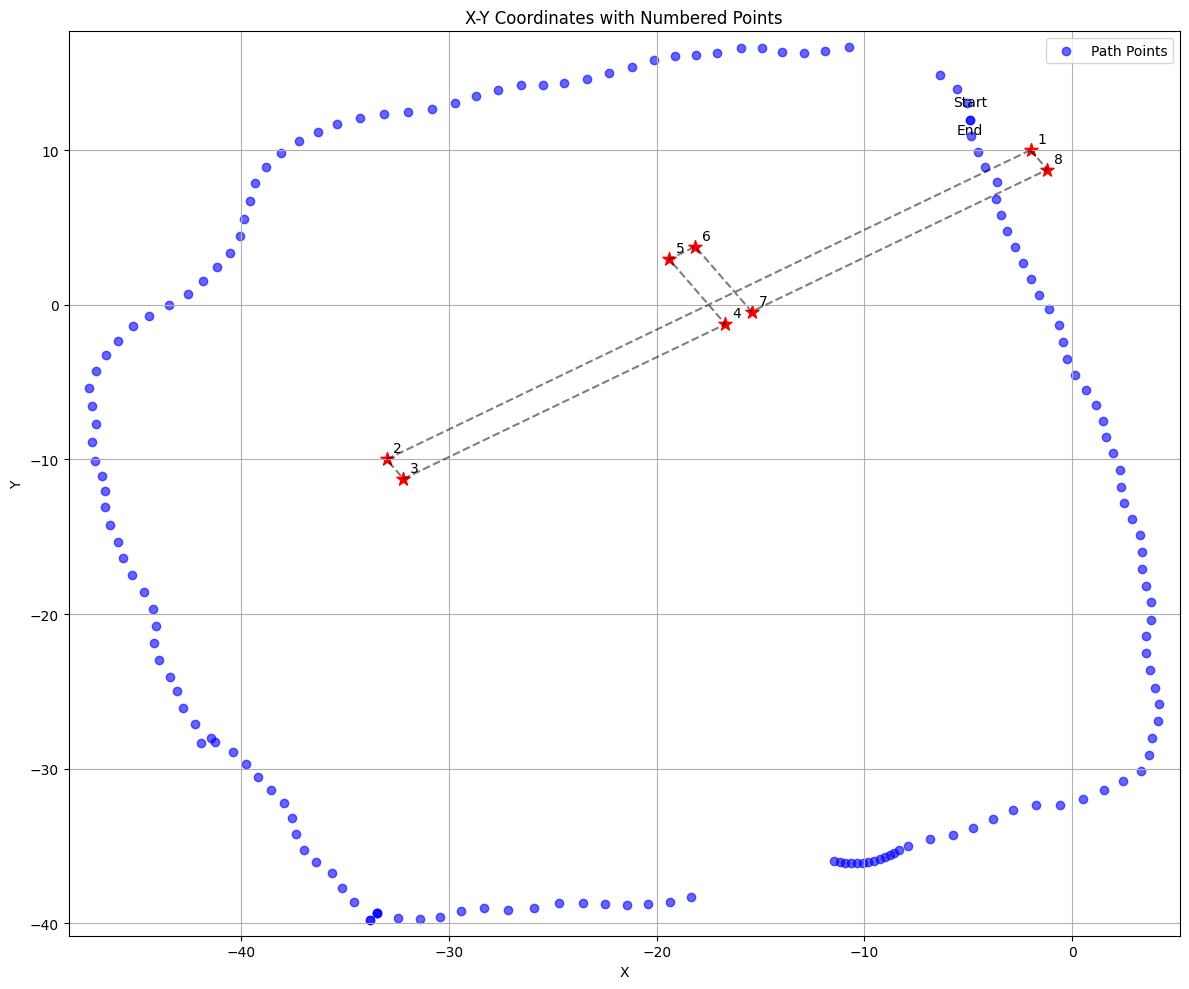

In [5]:
# Plot the points
plt.figure(figsize=(12, 10))

# Plot the original path points
plt.scatter(df_filtered['X'], df_filtered['Y'], color='blue', alpha=0.6, label='Path Points')

# Plot and label the points from the DataFrame
for i, row in points_df.iterrows():
    plt.scatter(row['X'], row['Y'], color='red', s=100, marker='*')
    plt.annotate(f'{i}', (row['X'], row['Y']), xytext=(5,5), textcoords='offset points')

# Draw lines connecting the points
plt.plot(points_df['X'].tolist() + [points_df['X'].iloc[0]], 
         points_df['Y'].tolist() + [points_df['Y'].iloc[0]], 'k--', alpha=0.5)

plt.title('X-Y Coordinates with Numbered Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Add labels for the first and last path points if needed
first_point = df_filtered.iloc[0]
last_point = df_filtered.iloc[-1]
plt.annotate('Start', (first_point['X'], first_point['Y']), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate('End', (last_point['X'], last_point['Y']), textcoords="offset points", xytext=(0,-10), ha='center')

plt.legend()

# Adjust the plot limits to include all points
plt.xlim(min(points_df['X'].min(), df_filtered['X'].min()) - 1, 
         max(points_df['X'].max(), df_filtered['X'].max()) + 1)
plt.ylim(min(points_df['Y'].min(), df_filtered['Y'].min()) - 1, 
         max(points_df['Y'].max(), df_filtered['Y'].max()) + 1)

plt.tight_layout()
plt.show()

In [6]:
import math
import pandas as pd

def calculate_angle(x1, y1, x2, y2):
    '''Calculates the directional angle with respect to the positive X-axis.'''
    angle = math.atan2(y2 - y1, x2 - x1)
    if angle < 0:
        angle += 2 * math.pi
    return round(angle, 2)

def update_df_with_angle_lookahead_speed(df, lookahead, speed):
    # Calculate angles
    angles = []
    for i in range(len(df)):
        if i == len(df) - 1:
            # For the last point, use the same angle as the previous point
            angles.append(angles[-1])
        else:
            x1, y1 = df.iloc[i]['X'], df.iloc[i]['Y']
            x2, y2 = df.iloc[i+1]['X'], df.iloc[i+1]['Y']
            angles.append(calculate_angle(x1, y1, x2, y2))
    
    # Add new columns
    df['angle'] = angles
    df['lookahead'] = lookahead
    df['speed'] = speed
    
    return df

# Use the points_df created earlier
lookahead = 2.5
speed = 0.50

# Update the DataFrame
updated_df = update_df_with_angle_lookahead_speed(points_df, lookahead, speed)

# Round X and Y to 2 decimal places
updated_df['X'] = updated_df['X'].round(2)
updated_df['Y'] = updated_df['Y'].round(2)

# Print the results
print(updated_df.to_string(index=True))

# Write to a .txt file
output_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/updated_points.txt'

# Write the DataFrame to the file without header and index
updated_df.to_csv(output_file_path, sep=' ', header=False, index=False, float_format='%.2f')

print(f"Data has been written to {output_file_path}")

       X      Y  angle  lookahead  speed
1  -2.00  10.00   3.71        2.5    0.5
2 -33.00 -10.00   5.29        2.5    0.5
3 -32.19 -11.26   0.57        2.5    0.5
4 -16.69  -1.26   2.14        2.5    0.5
5 -19.40   2.94   0.57        2.5    0.5
6 -18.14   3.75   5.29        2.5    0.5
7 -15.43  -0.45   0.57        2.5    0.5
8  -1.19   8.74   0.57        2.5    0.5
Data has been written to /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/updated_points.txt


After adjusting the angles and trimming the lookahead and speed I used the generator to produce this path.<br><br>
<img src="images/path_for_testing.png" alt="Path for testing" width="300px">

The adjusted angles are:<br>
-11.000000   4.000000   3.71<br>
-33.000000 -10.000000   3.71<br>
-32.194687 -11.265492   0.57<br>
-21.194687  -4.265492   1.36<br>
-23.879064  -0.047185   2.14<br>
-22.613572   0.758128   5.28<br>
-19.929195  -3.460179   5.90<br>
-10.194687   2.734508   0.57<br>
<br>I think if I wanted points 4 and 7 to be smoother then I would need to add two additional points.

In [7]:
#!/usr/bin/env python

import pandas as pd
import math
import dubins

def generate_path(x0, y0, x1, y1, theta0, theta1, turning_radius, step_size):
    q0 = (x0, y0, theta0)
    q1 = (x1, y1, theta1)
    continuous_path = dubins.shortest_path(q0, q1, turning_radius)
    calculated_path_segment, _ = continuous_path.sample_many(step_size)
    return calculated_path_segment

def calculate_curvature(p1, p2, p3):
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    x3, y3 = p3[0], p3[1]

    a = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    b = math.sqrt((x2 - x3)**2 + (y2 - y3)**2)
    c = math.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    s = (a + b + c) / 2

    area = s * (s - a) * (s - b) * (s - c)
    if area <= 0:
        return 0

    radius = a * b * c / (4 * math.sqrt(area))
    curvature = 1 / radius if radius != 0 else 0

    return curvature

def calculate_curvature_and_update_path(drive_path, alternate_lookahead, curvature_threshold):
    updated_drive_path = []
    for i in range(1, len(drive_path) - 1):
        p1, p2, p3 = drive_path[i - 1], drive_path[i], drive_path[i + 1]
        curvature = calculate_curvature(p1, p2, p3)

        if curvature > curvature_threshold:
            lookahead = alternate_lookahead
        else:
            lookahead = p2[3]

        updated_drive_path.append((p2[0], p2[1], p2[2], lookahead, p2[4]))

    return updated_drive_path

def main():
    def read_waypoints(input_file_path):
        df = pd.read_csv(input_file_path, sep=' ', header=None, names=['x', 'y', 'theta', 'lookahead', 'speed'])
        return df.values.tolist()

    def generate_drive_path(waypoints, turning_radius, step_size, lookahead, speed):
        drive_path = []
        x0, y0, theta0 = 0.0, 0.0, 0.0
        for idx, point in enumerate(waypoints):
            x1, y1, theta1 = point[0], point[1], point[2]
            if idx == 0:
                x0, y0, theta0 = x1, y1, theta1
                drive_path.append((x1, y1, theta1, lookahead, speed))
                continue
            try:
                calculated_path_segment = generate_path(x0, y0, x1, y1, theta0, theta1, turning_radius, step_size)
                for segment in calculated_path_segment:
                    segment += (lookahead, speed)
                    drive_path.append(segment)
            except RuntimeError as e:
                print(f"Error generating path from ({x0}, {y0}, {theta0}) to ({x1}, {y1}, {theta1})")
                print(f"Error message: {str(e)}")
                # Add the endpoint directly if path generation fails
                drive_path.append((x1, y1, theta1, lookahead, speed))
            x0, y0, theta0 = x1, y1, theta1
        return drive_path

    def write_output_txt(output_file_path, drive_path):
        with open(output_file_path, 'w') as f:
            for p in drive_path:
                f.write(f"{p[0]:.2f} {p[1]:.2f} {p[2]:.2f} {p[3]:.2f} {p[4]:.2f}\n")
        return len(drive_path)

    # main routine
    turning_radius = 1.3
    step_size = 0.3
    lookahead = 2.5
    alternate_lookahead = 1.0
    curvature_threshold = 0.02
    speed = 0.75

    input_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/updated_points.txt'
    output_file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/path_dubins_for_steering_test.txt'

    waypoints = read_waypoints(input_file_path)
    drive_path = generate_drive_path(waypoints, turning_radius, step_size, lookahead, speed)
    print("done with generate_drive_path")

    drive_path = calculate_curvature_and_update_path(drive_path, alternate_lookahead, curvature_threshold)
    print("done with calculate_curvature_and_update_path")

    total_count = write_output_txt(output_file_path, drive_path)
    print(f"Output file: {output_file_path}")
    print("Record count:", total_count, "turning_radius:", turning_radius, "step_size:", step_size)
    print("eoj")

if __name__ == "__main__":
    main()

done with generate_drive_path
done with calculate_curvature_and_update_path
Output file: /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/path_dubins_for_steering_test.txt
Record count: 349 turning_radius: 1.3 step_size: 0.3
eoj


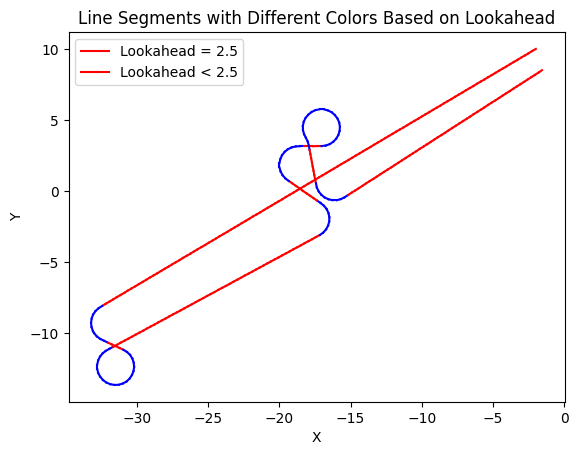

In [8]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to read data from a text file
def read_data(file_path):
    df = pd.read_csv(file_path, sep=' ', header=None, names=['x', 'y', 'theta', 'lookahead', 'speed'])
    points = df[['x', 'y', 'lookahead']].values.tolist()
    return points

# Function to plot the data
def plot_data(points):
    for i in range(len(points) - 1):
        x1, y1, lookahead1 = points[i]
        x2, y2, lookahead2 = points[i + 1]
        # Choose color based on lookahead value
        color = 'red' if lookahead1 == 2.5 else 'blue'
        # Plotting the line segment
        plt.plot([x1, x2], [y1, y2], color=color)

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Line Segments with Different Colors Based on Lookahead')
    plt.axis("equal")
    
    # Add legend
    plt.legend(['Lookahead = 2.5', 'Lookahead < 2.5'])

    # Show the plot
    plt.show()

# Main
file_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/Collins_Dr_62/site1_20240513/path_dubins_for_steering_test.txt'
data_points = read_data(file_path)
plot_data(data_points)

**Using the path just created**<br>
<br>The file 'input_path.txt' is the default path used for the program 'pure_pursuit.cpp' so I need to copy the output from above into that file.

In [17]:
import shutil
import os

# Source file 'file_path' from the cell above

# Destination file path
destination_path = '/home/tractor/ros1_lawn_tractor_ws/project_notes/paths/input_path.txt'

try:
    # Create the destination directory if it doesn't exist
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    
    # Copy the file
    shutil.copy2(file_path, destination_path)
    print(f"File successfully copied to {destination_path}")
except IOError as e:
    print(f"Unable to copy file. Error: {e}")
except:
    print("Unexpected error occurred while copying file")

File successfully copied to /home/tractor/ros1_lawn_tractor_ws/project_notes/paths/input_path.txt


**One Time Testing Snippets**

In [4]:
# test the mapping function for the steering control approach.
# '1850' is straight in that it returns zero which is what cmd_vel thinks is straight.
#
def mapfloat(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

left_limit_pot = 3210
right_limit_pot = 490
left_limit_angle = 0.96
right_limit_angle = -0.96

steering_actual_angle = mapfloat(1850, left_limit_pot, right_limit_pot, left_limit_angle, right_limit_angle)
print(f'Steering actual angle at pot value 1850: {steering_actual_angle}')
#unfotunately turning the steering to physically straight gives  1780, NOT 1850

steering_actual_angle = mapfloat(1780, left_limit_pot, right_limit_pot, left_limit_angle, right_limit_angle)
print(f'Steering actual angle at pot value 1780: {steering_actual_angle}')

steering_actual_angle = mapfloat(1855, left_limit_pot, right_limit_pot, left_limit_angle, right_limit_angle)
print(f'Steering actual angle at pot value 1855: {steering_actual_angle}')

steering_actual_angle = mapfloat(1983, left_limit_pot, right_limit_pot, left_limit_angle, right_limit_angle)
print(f'Steering actual angle at pot value 1983: {steering_actual_angle}')


Steering actual angle at pot value 1850: 0.0
Steering actual angle at pot value 1780: -0.049411764705882266
Steering actual angle at pot value 1855: 0.003529411764705892
Steering actual angle at pot value 1983: 0.09388235294117653


In [4]:
simple_middle = ((left_limit_pot - right_limit_pot)/2)+right_limit_pot
print(simple_middle)

1850.0


Steering actual angle at pot value 490: -0.9600
Steering actual angle at pot value 1000: -0.5805
Steering actual angle at pot value 1775: -0.0037
Steering actual angle at pot value 1780: 0.0000
Steering actual angle at pot value 1785: 0.0034
Steering actual angle at pot value 2500: 0.4834
Steering actual angle at pot value 3210: 0.9600


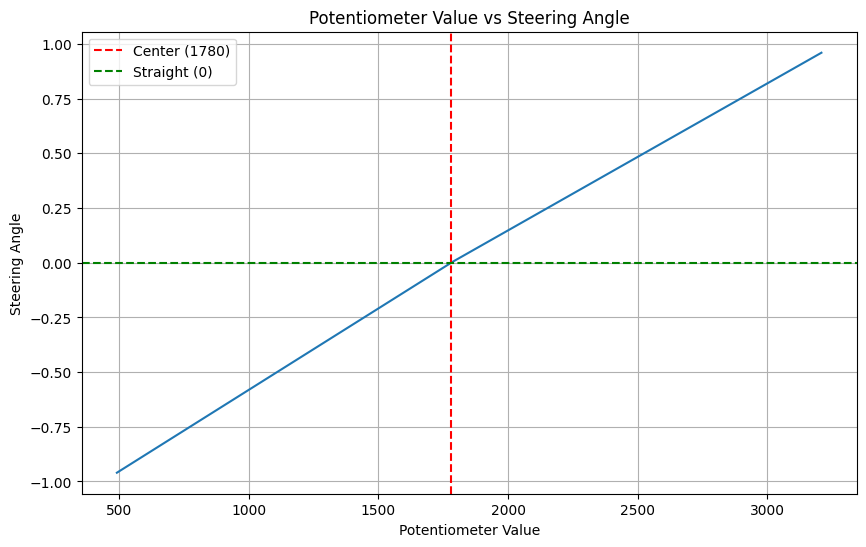

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def mapfloat(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def mapSteeringAngle(pot_value):
    CENTER_POT = 1780
    LEFT_LIMIT_POT = 3210
    RIGHT_LIMIT_POT = 490
    LEFT_LIMIT_ANGLE = 0.96
    RIGHT_LIMIT_ANGLE = -0.96
    
    if pot_value > CENTER_POT:
        return mapfloat(pot_value, CENTER_POT, LEFT_LIMIT_POT, 0, LEFT_LIMIT_ANGLE)
    elif pot_value < CENTER_POT:
        return mapfloat(pot_value, RIGHT_LIMIT_POT, CENTER_POT, RIGHT_LIMIT_ANGLE, 0)
    else:
        return 0  # Exactly at center

# Test the new mapping function
test_values = [490, 1000, 1775, 1780, 1785, 2500, 3210]
for value in test_values:
    angle = mapSteeringAngle(value)
    print(f'Steering actual angle at pot value {value}: {angle:.4f}')

# Visualize the mapping
pot_values = np.linspace(490, 3210, 1000)
angles = [mapSteeringAngle(val) for val in pot_values]

plt.figure(figsize=(10, 6))
plt.plot(pot_values, angles)
plt.title('Potentiometer Value vs Steering Angle')
plt.xlabel('Potentiometer Value')
plt.ylabel('Steering Angle')
plt.axvline(x=1780, color='r', linestyle='--', label='Center (1780)')
plt.axhline(y=0, color='g', linestyle='--', label='Straight (0)')
plt.legend()
plt.grid(True)
plt.show()

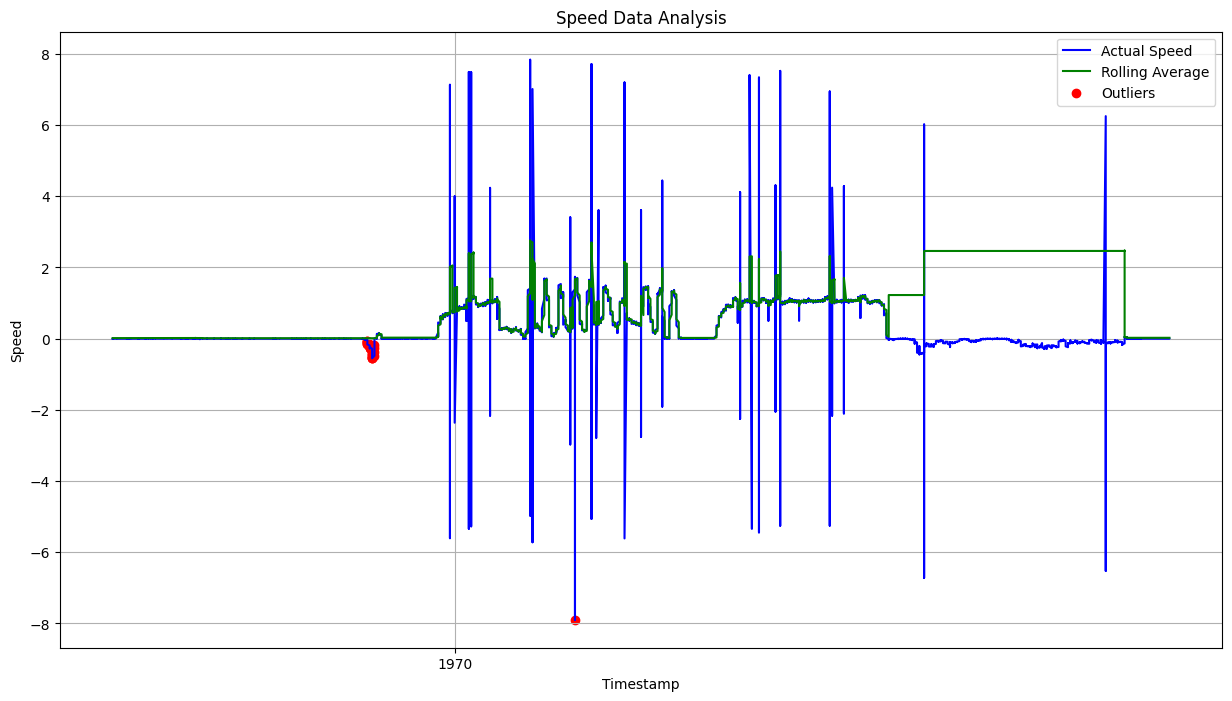

Filtered data saved to /home/tractor/wheel_data_right_filtered.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right.csv'
df = pd.read_csv(file_path)

# Convert the timestamp to a datetime object for better plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define a function to detect outliers
def detect_outliers(speed, rolling_avg, threshold=5):
    diff = np.abs(speed - rolling_avg)
    outliers = diff > (threshold * rolling_avg)
    return outliers

# Calculate the rolling average of the speed (excluding speeds <= 0.01)
rolling_window = 5
df['rolling_avg'] = df[df['speed'] > 0.01]['speed'].rolling(window=rolling_window, min_periods=1).mean()

# Fill NaN values in rolling_avg for better comparison
df['rolling_avg'].fillna(method='bfill', inplace=True)
df['rolling_avg'].fillna(method='ffill', inplace=True)

# Detect outliers in the speed data
df['is_outlier'] = detect_outliers(df['speed'], df['rolling_avg'])

# Plot the actual speed, the outliers, and the running average excluding the outliers
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['speed'], label='Actual Speed', color='blue')
plt.plot(df['timestamp'], df['rolling_avg'], label='Rolling Average', color='green')
plt.scatter(df['timestamp'][df['is_outlier']], df['speed'][df['is_outlier']], label='Outliers', color='red')

plt.xlabel('Timestamp')
plt.ylabel('Speed')
plt.title('Speed Data Analysis')
plt.legend()
plt.grid(True)
plt.show()

# Save the filtered data to a new CSV file
output_file_path = '/home/tractor/wheel_data_right_filtered.csv'
df.to_csv(output_file_path, index=False)
print(f"Filtered data saved to {output_file_path}")


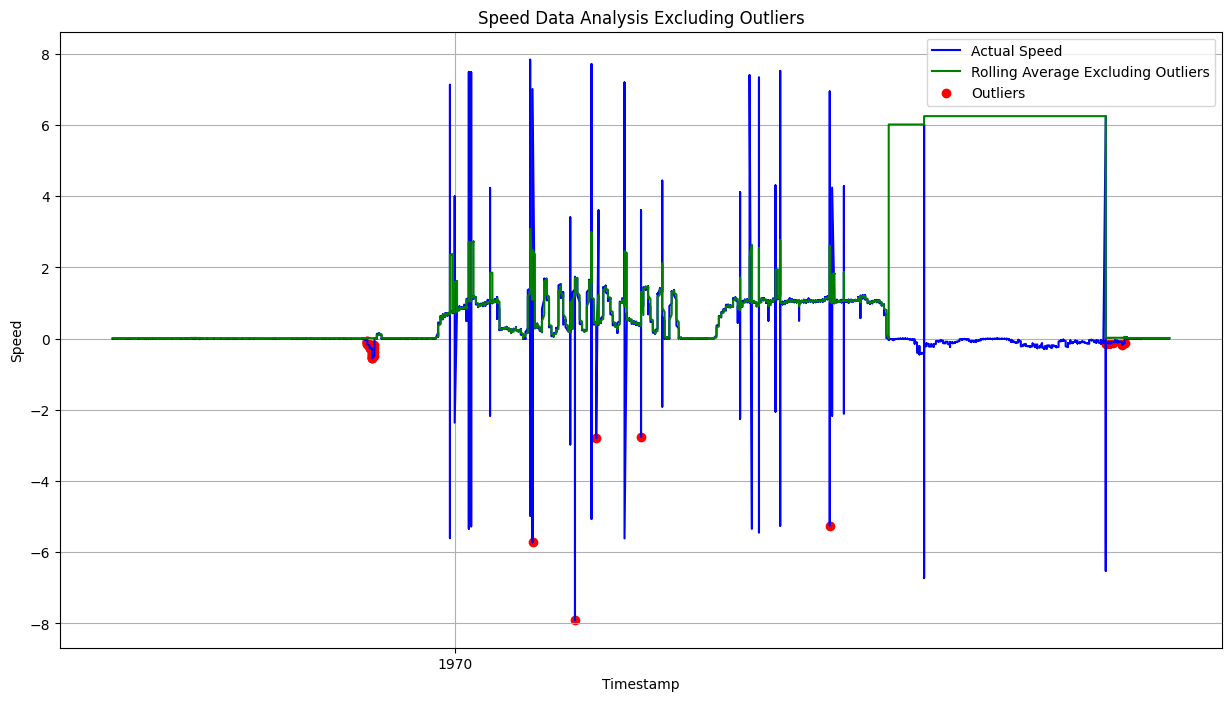

Filtered data saved to /home/tractor/wheel_data_right_filtered.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right.csv'
df = pd.read_csv(file_path)

# Convert the timestamp to a datetime object for better plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define a function to detect outliers
def detect_outliers(speed, rolling_avg, threshold=5):
    diff = np.abs(speed - rolling_avg)
    outliers = diff > (threshold * rolling_avg)
    return outliers

# Initialize a column for the rolling average excluding outliers
df['rolling_avg_excl_outliers'] = np.nan

# Define the rolling window size
rolling_window = 5

# Calculate the rolling average while excluding outliers
for i in range(len(df)):
    if i < rolling_window:
        df.loc[i, 'rolling_avg_excl_outliers'] = df.loc[:i, 'speed'][df['speed'][:i+1] > 0.01].mean()
    else:
        window_data = df.loc[i-rolling_window+1:i, 'speed'][df['speed'][i-rolling_window+1:i+1] > 0.01]
        rolling_avg = window_data.mean()
        if not detect_outliers(df.loc[i, 'speed'], rolling_avg):
            df.loc[i, 'rolling_avg_excl_outliers'] = rolling_avg
        else:
            df.loc[i, 'rolling_avg_excl_outliers'] = df.loc[i-rolling_window:i-1, 'rolling_avg_excl_outliers'].mean()

# Fill NaN values in rolling_avg_excl_outliers for better plotting
df['rolling_avg_excl_outliers'].fillna(method='bfill', inplace=True)
df['rolling_avg_excl_outliers'].fillna(method='ffill', inplace=True)

# Detect outliers again with the refined rolling average
df['is_outlier'] = detect_outliers(df['speed'], df['rolling_avg_excl_outliers'])

# Plot the actual speed, the outliers, and the running average excluding the outliers
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['speed'], label='Actual Speed', color='blue')
plt.plot(df['timestamp'], df['rolling_avg_excl_outliers'], label='Rolling Average Excluding Outliers', color='green')
plt.scatter(df['timestamp'][df['is_outlier']], df['speed'][df['is_outlier']], label='Outliers', color='red')

plt.xlabel('Timestamp')
plt.ylabel('Speed')
plt.title('Speed Data Analysis Excluding Outliers')
plt.legend()
plt.grid(True)
plt.show()

# Save the filtered data to a new CSV file
output_file_path = '/home/tractor/wheel_data_right_filtered.csv'
df.to_csv(output_file_path, index=False)
print(f"Filtered data saved to {output_file_path}")


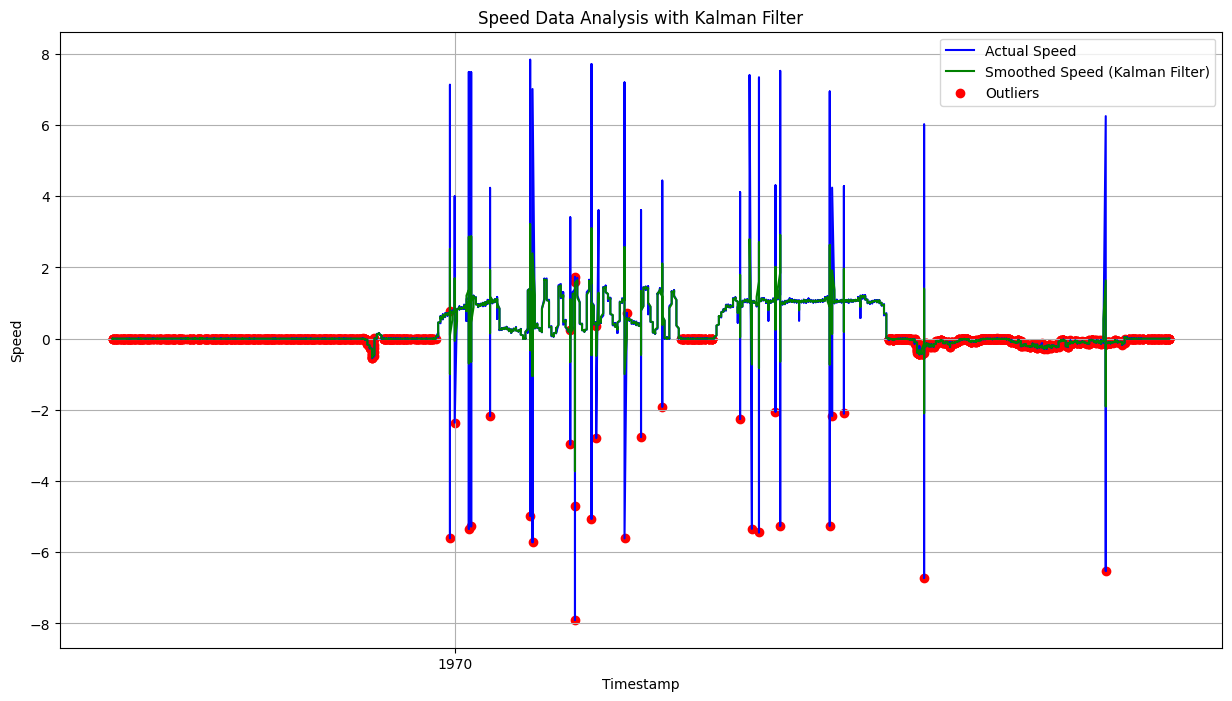

Filtered data saved to /home/tractor/wheel_data_right_filtered.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right.csv'
df = pd.read_csv(file_path)

# Convert the timestamp to a datetime object for better plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Initialize the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
measurements = df['speed'].values
state_means, _ = kf.smooth(measurements)

# Define a function to detect outliers
def detect_outliers(speed, smoothed_speed, threshold=5):
    diff = np.abs(speed - smoothed_speed)
    outliers = diff > (threshold * smoothed_speed)
    return outliers

# Apply the Kalman filter to smooth the data
df['smoothed_speed'] = state_means

# Detect outliers based on the Kalman filter output
df['is_outlier'] = detect_outliers(df['speed'], df['smoothed_speed'])

# Plot the actual speed, the outliers, and the smoothed speed
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['speed'], label='Actual Speed', color='blue')
plt.plot(df['timestamp'], df['smoothed_speed'], label='Smoothed Speed (Kalman Filter)', color='green')
plt.scatter(df['timestamp'][df['is_outlier']], df['speed'][df['is_outlier']], label='Outliers', color='red')

plt.xlabel('Timestamp')
plt.ylabel('Speed')
plt.title('Speed Data Analysis with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()

# Save the filtered data to a new CSV file
output_file_path = '/home/tractor/wheel_data_right_filtered.csv'
df.to_csv(output_file_path, index=False)
print(f"Filtered data saved to {output_file_path}")


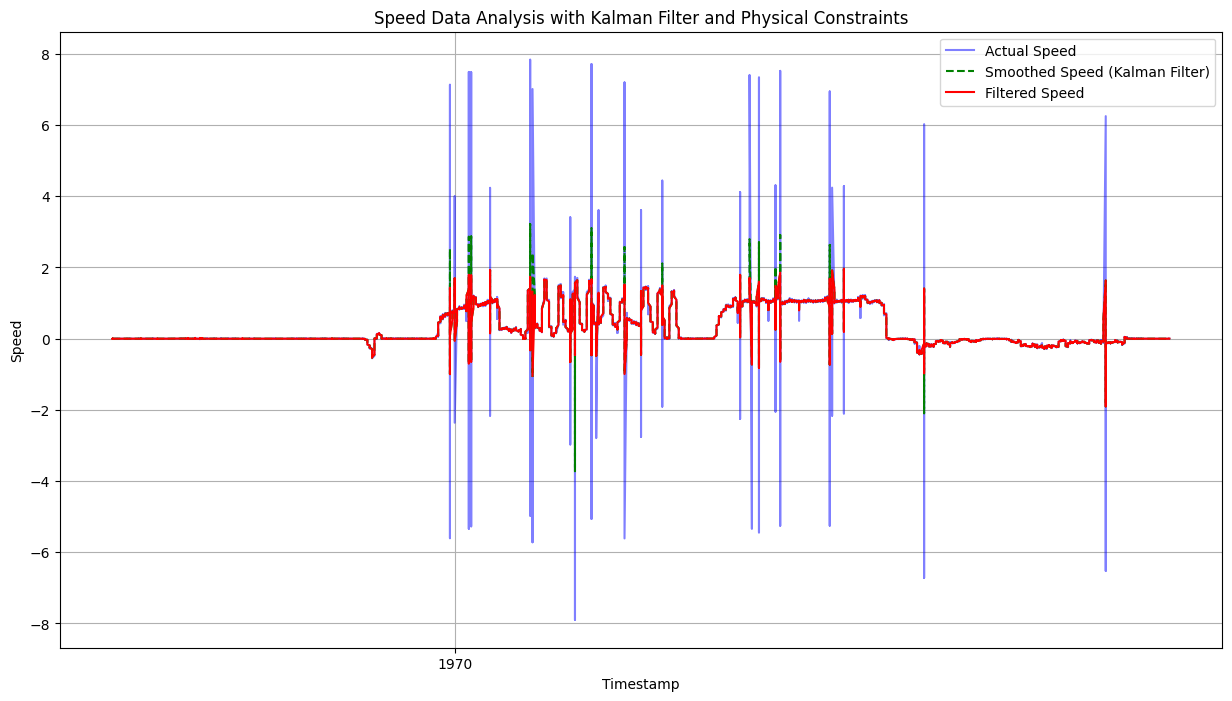

Filtered data saved to /home/tractor/wheel_data_right_filtered.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right.csv'
df = pd.read_csv(file_path)

# Convert the timestamp to a datetime object for better plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Initialize the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
measurements = df['speed'].values
state_means, _ = kf.smooth(measurements)

# Define physical limits for speed
speed_min = -2.0
speed_max = 2.0

# Apply the Kalman filter to smooth the data
df['smoothed_speed'] = state_means

# Post-process to filter out physically implausible values
df['filtered_speed'] = df['smoothed_speed'].apply(lambda x: x if speed_min <= x <= speed_max else np.nan)

# Fill NaN values by forward and backward filling
df['filtered_speed'].fillna(method='ffill', inplace=True)
df['filtered_speed'].fillna(method='bfill', inplace=True)

# Plot the actual speed, the smoothed speed, and the filtered speed
plt.figure(figsize=(15, 8))
plt.plot(df['timestamp'], df['speed'], label='Actual Speed', color='blue', alpha=0.5)
plt.plot(df['timestamp'], df['smoothed_speed'], label='Smoothed Speed (Kalman Filter)', color='green', linestyle='dashed')
plt.plot(df['timestamp'], df['filtered_speed'], label='Filtered Speed', color='red')

plt.xlabel('Timestamp')
plt.ylabel('Speed')
plt.title('Speed Data Analysis with Kalman Filter and Physical Constraints')
plt.legend()
plt.grid(True)
plt.show()

# Save the filtered data to a new CSV file
output_file_path = '/home/tractor/wheel_data_right_filtered.csv'
df.to_csv(output_file_path, index=False)
print(f"Filtered data saved to {output_file_path}")


In [2]:
import pandas as pd

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right.csv'
df = pd.read_csv(file_path)

# Print the columns in the dataframe to inspect the actual names
print("Columns in the dataframe:", df.columns)

# Display the first few rows to see the data structure
print(df.head())

Columns in the dataframe: Index(['timestamp', 'current_position', 'total_rotations', 'delta', 'speed'], dtype='object')
      timestamp  current_position  total_rotations  delta     speed
0  1.721769e+09            4966.0         0.000000   -1.0 -0.000974
1  1.721769e+09            4967.0         0.000061    1.0  0.000974
2  1.721769e+09            4967.0         0.000061    0.0  0.000000
3  1.721769e+09            4967.0         0.000061    0.0  0.000000
4  1.721769e+09            4966.0         0.000000   -1.0 -0.000974


In [4]:
import pandas as pd

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right.csv'
df = pd.read_csv(file_path)

# Define thresholds for detecting wrap-around transitions
high_threshold = 14000
low_threshold = 2000

# Function to detect transitions
def detect_wrap_around_transitions(df):
    transitions = []
    for i in range(1, len(df)):
        last_position = df.loc[i-1, 'current_position']
        current_position = df.loc[i, 'current_position']
        
        if last_position > high_threshold and current_position < low_threshold:
            delta = current_position + (16384 - last_position)
            transitions.append((i, last_position, current_position, delta, 'wrap-around down'))
        elif last_position < low_threshold and current_position > high_threshold:
            delta = (current_position - 16384) - last_position
            transitions.append((i, last_position, current_position, delta, 'wrap-around up'))
    
    return transitions

# Detect wrap-around transitions
wrap_around_transitions = detect_wrap_around_transitions(df)

# Print out the detected wrap-around transitions
for index, last_position, current_position, delta, transition_type in wrap_around_transitions:
    print(f"Index: {index}, Last Position: {last_position}, Current Position: {current_position}, Delta: {delta}, Transition Type: {transition_type}")

# Optional: Save the wrap-around transitions to a new CSV file for further analysis
wrap_around_transitions_df = pd.DataFrame(wrap_around_transitions, columns=['Index', 'Last Position', 'Current Position', 'Delta', 'Transition Type'])
output_file_path = '/home/tractor/wheel_data_right_wrap_around_transitions.csv'
wrap_around_transitions_df.to_csv(output_file_path, index=False)
print(f"Wrap-around transition data saved to {output_file_path}")


Index: 1101, Last Position: 155.0, Current Position: 16085.0, Delta: -454.0, Transition Type: wrap-around up
Index: 1385, Last Position: 16067.0, Current Position: 129.0, Delta: 446.0, Transition Type: wrap-around down
Index: 1412, Last Position: 16127.0, Current Position: 445.0, Delta: 702.0, Transition Type: wrap-around down
Index: 1475, Last Position: 16173.0, Current Position: 676.0, Delta: 887.0, Transition Type: wrap-around down
Index: 1493, Last Position: 15743.0, Current Position: 227.0, Delta: 868.0, Transition Type: wrap-around down
Index: 1538, Last Position: 15615.0, Current Position: 417.0, Delta: 1186.0, Transition Type: wrap-around down
Index: 1554, Last Position: 15709.0, Current Position: 300.0, Delta: 975.0, Transition Type: wrap-around down
Index: 1571, Last Position: 16006.0, Current Position: 645.0, Delta: 1023.0, Transition Type: wrap-around down
Index: 1587, Last Position: 15704.0, Current Position: 332.0, Delta: 1012.0, Transition Type: wrap-around down
Index: 1

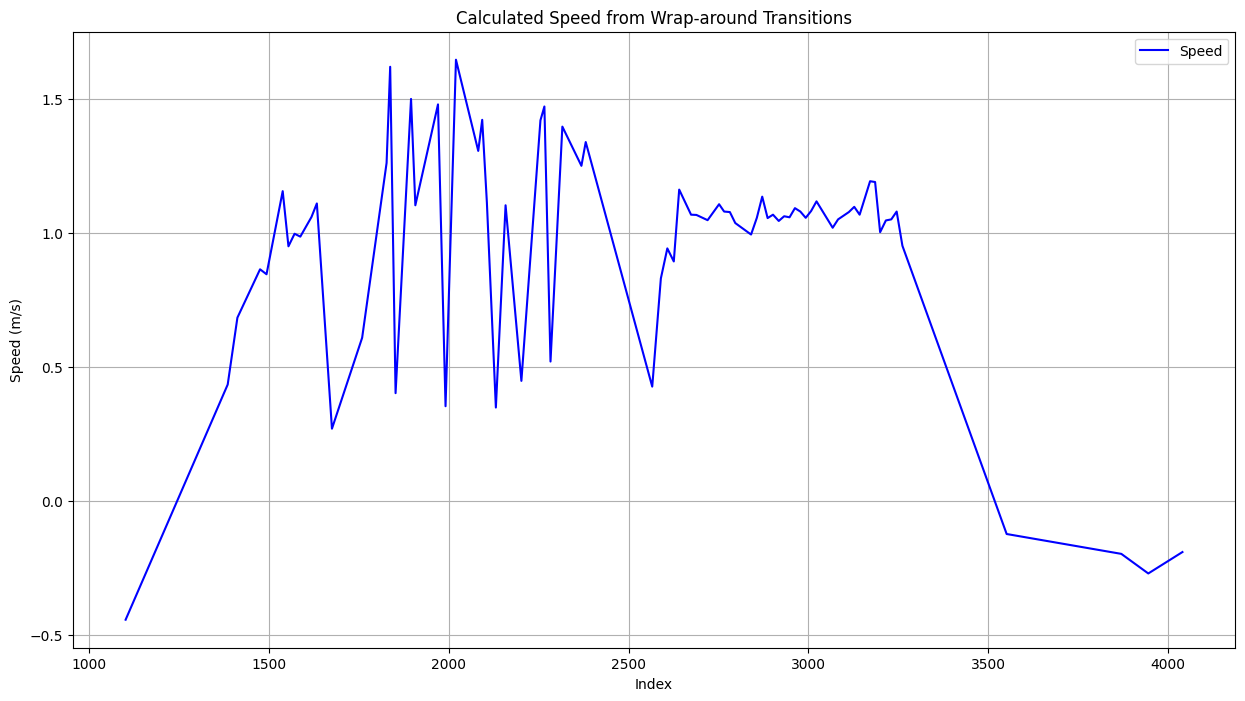

Speed data saved to /home/tractor/wheel_data_right_wrap_around_transitions_speed.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right_wrap_around_transitions.csv'
df = pd.read_csv(file_path)

# Define constants
TICKS_PER_REVOLUTION = 16384.0  # 2^14 ticks per full rotation
WHEEL_CIRCUMFERENCE = 1.59593   # Wheel circumference in meters (20" diameter)
OUTPUT_INTERVAL = 100           # Output interval in milliseconds

# Function to calculate speed
def calculate_speed(df):
    speeds = []
    for i in range(len(df)):
        delta = df.loc[i, 'Delta']
        rotations_per_second = (float(delta) / TICKS_PER_REVOLUTION) * (1000.0 / OUTPUT_INTERVAL)
        speed = rotations_per_second * WHEEL_CIRCUMFERENCE
        speeds.append(speed)
    return speeds

# Calculate speed
df['speed'] = calculate_speed(df)

# Plot the speed
plt.figure(figsize=(15, 8))
plt.plot(df['Index'], df['speed'], label='Speed', color='blue')

plt.xlabel('Index')
plt.ylabel('Speed (m/s)')
plt.title('Calculated Speed from Wrap-around Transitions')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Save the speed data to a new CSV file
output_file_path = '/home/tractor/wheel_data_right_wrap_around_transitions_speed.csv'
df.to_csv(output_file_path, index=False)
print(f"Speed data saved to {output_file_path}")


In [6]:
import pandas as pd

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right_wrap_around_transitions.csv'
df = pd.read_csv(file_path)

# Calculate the absolute value of delta
df['abs_delta'] = df['Delta'].abs()

# Calculate the minimum and maximum of the absolute value of delta
min_abs_delta = df['abs_delta'].min()
max_abs_delta = df['abs_delta'].max()

# Print the results
print(f"Minimum absolute value of delta: {min_abs_delta}")
print(f"Maximum absolute value of delta: {max_abs_delta}")

# Optional: Save the results to a new CSV file
output_file_path = '/home/tractor/wheel_data_right_wrap_around_transitions_min_max_delta.csv'
result_df = pd.DataFrame({
    'min_abs_delta': [min_abs_delta],
    'max_abs_delta': [max_abs_delta]
})
result_df.to_csv(output_file_path, index=False)
print(f"Results saved to {output_file_path}")


Minimum absolute value of delta: 126.0
Maximum absolute value of delta: 1689.0
Results saved to /home/tractor/wheel_data_right_wrap_around_transitions_min_max_delta.csv


In [10]:
'''
Identify records between 0 and 2000 in the current_position column, and for each of those records, 
capture the previous three and the next three current_position values.
'''

import pandas as pd

# Load the data from the CSV file
file_path = '/home/tractor/wheel_data_right.csv'
df = pd.read_csv(file_path)

# Function to capture previous three and next three position values around records with current_position between 0 and 2000
def capture_surrounding_values(df):
    results = []
    for i in range(len(df)):
        current_position = df.loc[i, 'current_position']
        if 0 <= current_position <= 2000:
            previous_readings = df.loc[max(i-3, 0):i-1, 'current_position'].values
            next_readings = df.loc[i+1:i+3, 'current_position'].values
            
            # Ensure we capture exactly three values for previous and next readings
            previous_readings = [None]*(3-len(previous_readings)) + list(previous_readings)
            next_readings = list(next_readings) + [None]*(3-len(next_readings))
            
            results.append((i, current_position, previous_readings, next_readings))
    
    return results

# Capture the surrounding values
surrounding_values = capture_surrounding_values(df)

# Create a DataFrame for the results
surrounding_values_data = {
    'Index': [t[0] for t in surrounding_values],
    'Current Position': [t[1] for t in surrounding_values],
    'Previous Reading 1': [t[2][0] for t in surrounding_values],
    'Previous Reading 2': [t[2][1] for t in surrounding_values],
    'Previous Reading 3': [t[2][2] for t in surrounding_values],
    'Next Reading 1': [t[3][0] for t in surrounding_values],
    'Next Reading 2': [t[3][1] for t in surrounding_values],
    'Next Reading 3': [t[3][2] for t in surrounding_values]
}
surrounding_values_df = pd.DataFrame(surrounding_values_data)

# Save the results to a new CSV file
output_file_path = '/home/tractor/wheel_data_right_surrounding_values.csv'
surrounding_values_df.to_csv(output_file_path, index=False)
print(f"Surrounding values data saved to {output_file_path}")


Surrounding values data saved to /home/tractor/wheel_data_right_surrounding_values.csv


In [11]:
import pandas as pd

# Define the path to the CSV file
input_file_path = '/home/tractor/wheel_data_right_surrounding_values.csv'
output_file_path = '/home/tractor/wheel_data_right_near_ticks_per_revolution.csv'

# Load the data from the CSV file
df = pd.read_csv(input_file_path)

# Define the threshold for being "near" TICKS_PER_REVOLUTION
threshold = 15000

# Filter records where 'Previous Reading 3' or 'Next Reading 1' is greater than 15,000
filtered_df = df[(df['Previous Reading 3'] > threshold) | (df['Next Reading 1'] > threshold)]

# Save the filtered results to a new CSV file
filtered_df.to_csv(output_file_path, index=False)
print(f"Filtered data saved to {output_file_path}")


Filtered data saved to /home/tractor/wheel_data_right_near_ticks_per_revolution.csv


In [13]:
import pandas as pd

# Define the file paths
original_file_path = '/home/tractor/wheel_data_right.csv'
valid_rollover_file_path = '/home/tractor/wheel_data_right_near_ticks_per_revolution.csv'
output_invalid_rollover_file_path = '/home/tractor/wheel_data_right_invalid_rollover_events.csv'

# Load the original data
df_original = pd.read_csv(original_file_path)

# Load the valid roll-over events data
df_valid_rollover = pd.read_csv(valid_rollover_file_path)

# Define the threshold for being "near" TICKS_PER_REVOLUTION
threshold = 15000

# Function to capture previous three and next three position values
def capture_surrounding_values(df):
    results = []
    for i in range(len(df)):
        current_position = df.loc[i, 'current_position']
        previous_readings = df.loc[max(i-3, 0):i-1, 'current_position'].values
        next_readings = df.loc[i+1:i+3, 'current_position'].values
        
        # Ensure we capture exactly three values for previous and next readings
        previous_readings = [None]*(3-len(previous_readings)) + list(previous_readings)
        next_readings = list(next_readings) + [None]*(3-len(next_readings))
        
        results.append((i, current_position, previous_readings, next_readings))
    
    return results

# Capture the surrounding values
surrounding_values = capture_surrounding_values(df_original)

# Create a DataFrame for the results
surrounding_values_data = {
    'Index': [t[0] for t in surrounding_values],
    'Previous Reading 1': [t[2][0] for t in surrounding_values],
    'Previous Reading 2': [t[2][1] for t in surrounding_values],
    'Previous Reading 3': [t[2][2] for t in surrounding_values],
    'Current Position': [t[1] for t in surrounding_values],
    'Next Reading 1': [t[3][0] for t in surrounding_values],
    'Next Reading 2': [t[3][1] for t in surrounding_values],
    'Next Reading 3': [t[3][2] for t in surrounding_values]
}
df_surrounding_values = pd.DataFrame(surrounding_values_data)

# Save the surrounding values data to a CSV file (for reference)
df_surrounding_values.to_csv('/home/tractor/wheel_data_right_surrounding_values.csv', index=False)

# Filter records where 'Previous Reading 3' or 'Next Reading 1' is greater than 15,000
all_rollover_events = df_surrounding_values[(df_surrounding_values['Previous Reading 3'] > threshold) | (df_surrounding_values['Next Reading 1'] > threshold)]

# Identify invalid roll-over events by comparing with valid roll-over events
invalid_rollover_events = pd.merge(all_rollover_events, df_valid_rollover, how='outer', indicator=True)
invalid_rollover_events = invalid_rollover_events[invalid_rollover_events['_merge'] == 'left_only']
invalid_rollover_events = invalid_rollover_events.drop(columns=['_merge'])

# Reorder columns
invalid_rollover_events = invalid_rollover_events[['Index', 'Previous Reading 1', 'Previous Reading 2', 'Previous Reading 3', 'Current Position', 'Next Reading 1', 'Next Reading 2', 'Next Reading 3']]

# Save the invalid roll-over events to a new CSV file
invalid_rollover_events.to_csv(output_invalid_rollover_file_path, index=False)
print(f"Invalid roll-over events data saved to {output_invalid_rollover_file_path}")


Invalid roll-over events data saved to /home/tractor/wheel_data_right_invalid_rollover_events.csv


In [17]:
import pandas as pd

# Define the file paths
original_file_path = '/home/tractor/wheel_data_right.csv'
output_filtered_file_path = '/home/tractor/wheel_data_right_filtered.csv'

# Load the original data
df_original = pd.read_csv(original_file_path)

# Define the threshold values
threshold_prev_reading_3 = 15000
threshold_prev_reading_2 = 13000

# Function to capture previous three and next three position values
def capture_surrounding_values(df):
    results = []
    for i in range(len(df)):
        current_position = df.loc[i, 'current_position']
        previous_readings = df.loc[max(i-3, 0):i-1, 'current_position'].values
        next_readings = df.loc[i+1:i+3, 'current_position'].values
        
        # Ensure we capture exactly three values for previous and next readings
        previous_readings = [None]*(3-len(previous_readings)) + list(previous_readings)
        next_readings = list(next_readings) + [None]*(3-len(next_readings))
        
        results.append((i, current_position, previous_readings, next_readings))
    
    return results

# Capture the surrounding values
surrounding_values = capture_surrounding_values(df_original)

# Create a DataFrame for the results
surrounding_values_data = {
    'Index': [t[0] for t in surrounding_values],
    'Previous Reading 1': [t[2][0] for t in surrounding_values],
    'Previous Reading 2': [t[2][1] for t in surrounding_values],
    'Previous Reading 3': [t[2][2] for t in surrounding_values],
    'Current Position': [t[1] for t in surrounding_values],
    'Next Reading 1': [t[3][0] for t in surrounding_values],
    'Next Reading 2': [t[3][1] for t in surrounding_values],
    'Next Reading 3': [t[3][2] for t in surrounding_values]
}
df_surrounding_values = pd.DataFrame(surrounding_values_data)

# Apply the filtering criteria
filtered_df = df_surrounding_values[
    (df_surrounding_values['Previous Reading 3'] > threshold_prev_reading_3) &
    (df_surrounding_values['Previous Reading 2'] > threshold_prev_reading_2) &
    (df_surrounding_values['Previous Reading 3'] > df_surrounding_values['Previous Reading 2']) &
    (df_surrounding_values['Previous Reading 2'] > df_surrounding_values['Previous Reading 1']) &
    (df_surrounding_values['Current Position'] > 2000) &
    (df_surrounding_values['Current Position'] < df_surrounding_values['Previous Reading 3'])
]

# Reorder columns
filtered_df = filtered_df[['Index', 'Previous Reading 1', 'Previous Reading 2', 'Previous Reading 3', 'Current Position', 'Next Reading 1', 'Next Reading 2', 'Next Reading 3']]

# Save the filtered data to a new CSV file
filtered_df.to_csv(output_filtered_file_path, index=False)
print(f"Filtered data saved to {output_filtered_file_path}")



Filtered data saved to /home/tractor/wheel_data_right_filtered.csv


In [11]:
# this is to find the aborations when travelling in reverse.  I want to find the instances where the current position 
# is not in sequence from say 400 -> 200 -> 16300 -> 16100; An aboration would be 400 -> 200 -> 6000 -> 16100
# We would want to disgard the 6000 event
#
import pandas as pd

# Define the file paths
original_file_path = '/home/tractor/wheel_data_right.csv'
output_filtered_file_path = '/home/tractor/wheel_data_right_filtered_for_reverse.csv'

# Load the original data
df_original = pd.read_csv(original_file_path)

# Define the threshold values
threshold_prev_reading_3 = 15000
threshold_prev_reading_2 = 13000

# Function to capture previous three and next three position values
def capture_surrounding_values(df):
    results = []
    for i in range(len(df)):
        current_position = df.loc[i, 'current_position']
        previous_readings = df.loc[max(i-3, 0):i-1, 'current_position'].values
        next_readings = df.loc[i+1:i+3, 'current_position'].values
        
        # Ensure we capture exactly three values for previous and next readings
        previous_readings = [None]*(3-len(previous_readings)) + list(previous_readings)
        next_readings = list(next_readings) + [None]*(3-len(next_readings))
        
        results.append((i, current_position, previous_readings, next_readings))
    
    return results

# Capture the surrounding values
surrounding_values = capture_surrounding_values(df_original)

# Create a DataFrame for the results
surrounding_values_data = {
    'Index': [t[0] for t in surrounding_values],
    'Previous Reading 1': [t[2][0] for t in surrounding_values],
    'Previous Reading 2': [t[2][1] for t in surrounding_values],
    'Previous Reading 3': [t[2][2] for t in surrounding_values],
    'Current Position': [t[1] for t in surrounding_values],
    'Next Reading 1': [t[3][0] for t in surrounding_values],
    'Next Reading 2': [t[3][1] for t in surrounding_values],
    'Next Reading 3': [t[3][2] for t in surrounding_values]
}
df_surrounding_values = pd.DataFrame(surrounding_values_data)

# Apply the filtering criteria
filtered_df = df_surrounding_values[
    (df_surrounding_values['Previous Reading 3'] < 200) &
    (df_surrounding_values['Previous Reading 2'] < 600) &
    (df_surrounding_values['Previous Reading 3'] < df_surrounding_values['Previous Reading 2']) &
    (df_surrounding_values['Previous Reading 2'] < df_surrounding_values['Previous Reading 1']) &
    (df_surrounding_values['Current Position'] < 14000)]
#    (df_surrounding_values['Current Position'] > df_surrounding_values['Previous Reading 3'])
#]

# Reorder columns
filtered_df = filtered_df[['Index', 'Previous Reading 1', 'Previous Reading 2', 'Previous Reading 3', 'Current Position', 'Next Reading 1', 'Next Reading 2', 'Next Reading 3']]

# Save the filtered data to a new CSV file
filtered_df.to_csv(output_filtered_file_path, index=False)
print(f"Filtered data saved to {output_filtered_file_path}")



Filtered data saved to /home/tractor/wheel_data_right_filtered_for_reverse.csv
